In [378]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import pandas as pd
import os, sys
import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

import fire

In [384]:
import sys
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# to view all columns
pd.set_option("display.max.columns", None)

In [3]:
#Import the necessary methods from tweepy library  

#install tweepy if you don't have it
#!pip install tweepy
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

#sentiment analysis package
#!pip install textblob
from textblob import TextBlob

#general text pre-processor
#!pip install nltk
import nltk
from nltk.corpus import stopwords
# nltk.download('punkt')

#tweet pre-processor 
#!pip install tweet-preprocessor
import preprocessor as p

In [4]:
#%%writefile ../pyscrap_url.py

def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content  #.encode(BeautifulSoup.original_encoding)
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)
    
def get_elements(url, tag='',search={}, fname=None):
    """
    Downloads a page specified by the url parameter
    and returns a list of strings, one per tag element
    """
    
    if isinstance(url,str):
        response = simple_get(url)
    else:
        #if already it is a loaded html page
        response = url

    if response is not None:
        html = BeautifulSoup(response, 'html.parser')
        
        res = []
        if tag:    
            for li in html.select(tag):
                for name in li.text.split('\n'):
                    if len(name) > 0:
                        res.append(name.strip())
                             
        if search:
            soup = html            
            
            
            r = ''
            if 'find' in search.keys():
                print('finding',search['find'])
                soup = soup.find(**search['find'])
                r = soup

                
            if 'find_all' in search.keys():
                print('findaing all of',search['find_all'])
                r = soup.find_all(**search['find_all'])
            if r:
                for x in list(r):
                    if len(x) > 0:
                        res.extend(x)
            
        return res

    # Raise an exception if we failed to get any data from the url
    raise Exception('Error retrieving contents at {}'.format(url))    
    
    
if get_ipython().__class__.__name__ == '__main__':
    fire(get_tag_elements)

In [5]:
res = get_elements('https://africafreak.com/100-most-influential-twitter-users-in-africa',tag='h2')


In [6]:
url= 'https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/#east-africa'
response = simple_get(url)

In [7]:
result = get_elements(response, search={'find_all':{'class_':'wp-block-embed__wrapper'}})


findaing all of {'class_': 'wp-block-embed__wrapper'}


In [24]:
consumer_key = 'gaGNsJKDKlofnPH94ppdrCeTd'
consumer_secret = 'zLiCEI1R5ucDMlXd2QtYtAAG1DKfaKKElFFVxLacwvghYuqtfC'
access_token = '1013077926634500096-3snJJ1lR0NXnTgrRq82sFbaRYxHVjm'
access_token_secret = 'rr27t3uyWqvv5pbfpPSigoKIvwyGHzEpxYn3hHygZKVNk'
            
#This handles Twitter authetification and the connection to Twitter Streaming API
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
            
auth = auth
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True) 

In [9]:
def clean_tweets(twitter_text):

    #use pre processor
    tweet = p.clean(twitter_text)

     #HappyEmoticons
    emoticons_happy = set([
        ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
        ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
        '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
        'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
        '<3'
        ])

    # Sad Emoticons
    emoticons_sad = set([
        ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
        ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
        ':c', ':{', '>:\\', ';('
        ])

    #Emoji patterns
    emoji_pattern = re.compile("["
             u"\U0001F600-\U0001F64F"  # emoticons
             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
             u"\U0001F680-\U0001F6FF"  # transport & map symbols
             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
             u"\U00002702-\U000027B0"
             u"\U000024C2-\U0001F251"
             "]+", flags=re.UNICODE)

    #combine sad and happy emoticons
    emoticons = emoticons_happy.union(emoticons_sad)

    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(tweet)
    #after tweepy preprocessing the colon symbol left remain after      
    #removing mentions
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)

    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)

    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]

    #looping through conditions
    filtered_tweet = []    
    for w in word_tokens:
    #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)

    return ' '.join(filtered_tweet)            

In [25]:
def get_tweets(username, csvfile):
        #page attribute in tweepy.cursor and iteration
    cols =  ['id', 'created_at', 'source', 'original_text','clean_text', 
                        'sentiment','polarity','subjectivity', 'lang',
                        'favorite_count', 'retweet_count', 'original_author',   
                        'possibly_sensitive', 'followers_count', 'friends_count', 'statuses_count',
                         'hashtags', 'user_mentions', 'place', 'place_coord_boundaries']
    
    df = pd.DataFrame(columns=cols)

    if not csvfile is None:
        #If the file exists, then read the existing data from the CSV file.
        if os.path.exists(csvfile):
            df = pd.read_csv(csvfile, header=0)
    for page in tweepy.Cursor(api.user_timeline, screen_name=username, count=20,
                              include_rts=False).pages(5):

        # the data you receive from the Twitter API is in a JSON format and has quite an amount of information attached
        for status in page:

            new_entry = []
            status = status._json
            #filter by language
            if status['lang'] != 'en':
                continue
            #if this tweet is a retweet update retweet count
            if status['created_at'] in df['created_at'].values:
                i = df.loc[df['created_at'] == status['created_at']].index[0]
                #
                cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                if cond1 or cond2:
                    df.at[i, 'favorite_count'] = status['favorite_count']
                    df.at[i, 'retweet_count'] = status['retweet_count']
                continue

            #calculate sentiment
            filtered_tweet = clean_tweets(twitter_text=status['text'])
            blob = TextBlob(filtered_tweet)
            Sentiment = blob.sentiment     
            polarity = Sentiment.polarity
            subjectivity = Sentiment.subjectivity

            new_entry += [status['id'], status['created_at'],
                          status['source'], status['text'], filtered_tweet, 
                          Sentiment,polarity,subjectivity, status['lang'],
                          status['favorite_count'], status['retweet_count']]

            new_entry.append(status['user']['screen_name'])

            try:
                is_sensitive = status['possibly_sensitive']
            except KeyError:
                is_sensitive = None

            new_entry.append(is_sensitive)
            new_entry.append(status['user']['followers_count'])
            new_entry.append(status['user']['friends_count'])
            new_entry.append(status['user']['statuses_count'])
    #         new_entry.append(status['reply_count'])
    #         print('len of new entry', len(new_entry))

            hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
            new_entry.append(hashtags) #append the hashtags

            #
            mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
            new_entry.append(mentions) #append the user mentions

            try:
                xyz = status['place']['bounding_box']['coordinates']
                coordinates = [coord for loc in xyz for coord in loc]
            except TypeError:
                coordinates = None
            #
            new_entry.append(coordinates)

            try:
                location = status['user']['location']
            except TypeError:
                location = ''
            #
            new_entry.append(location)

            #now append a row to the dataframe
            single_tweet_df = pd.DataFrame([new_entry], columns=cols)
            df = df.append(single_tweet_df, ignore_index=True)
            
    if not csvfile is None:
        #save it to file
        df.to_csv(csvfile, columns=cols, index=False, encoding="utf-8")
            
        return df

In [41]:
# pattern = r'@[a-zA-Z]+'
# leaders_name = re.findall(pattern, str(result))
# leaders_name = list(set(leaders_name))
# valid_leaders_names = []
# for leader in leaders_name:
#     try:
#         a = api.get_user(leader)
#         if a.protected: print(f'{leader} is protected')
#         else: valid_leaders_names.append(a.screen_name)
#     except:
#         print(f'{leader} Not Valid', end=', ')
# len(valid_leaders_names)

@President Not Valid, @M Not Valid, @Dora Not Valid, @angola is protected
@ChitaluChilufy Not Valid, @EswatiniGovern Not Valid, @Presidence Not Valid, @Presidency Not Valid, 

40

In [43]:
# pattern = r'@[\da-zA-Z]+'

# influence_names = re.findall(pattern, str(res))
# influence_names = list(set(influence_names))
# valid_influential_names = []
# for influential in influence_names:
#     try:
#         a = api.get_user(influential)
#         if a.protected: print(f'{influential} is protected')
#         else: valid_influential_names.append(a.screen_name)
#     except:
#         print(f'{influential} Not Valid', end=', ')
# len(valid_influential_names)

@Afrinnovator Not Valid, @mary is protected
@BBCKarenAllen Not Valid, @702JohnRobbie Not Valid, @andBeyondSafari Not Valid, @hurricanevaness Not Valid, @Julius Not Valid, @drewfhinshaw Not Valid, 

92

In [46]:
# filename = 'leaders_tweets_data.csv'
# for leader in valid_leaders_names:
#     leader_data = get_tweets(leader, filename)
#     print(f'Done Downloading and Saving {leader} tweets')
# leader_data.shape

Done Downloading and Saving MalawiGovt tweets
Done Downloading and Saving edmnangagwa tweets
Done Downloading and Saving MBuhari tweets
Done Downloading and Saving gouvbenin tweets
Done Downloading and Saving StateHouseKenya tweets
Done Downloading and Saving rochkaborepf tweets
Done Downloading and Saving PresidencyZA tweets
Done Downloading and Saving mohzambia tweets
Done Downloading and Saving FinanceSC tweets
Done Downloading and Saving PresidenceBenin tweets
Done Downloading and Saving noalaskinner tweets
Done Downloading and Saving Cherif tweets
Done Downloading and Saving SouthSudanGov tweets
Done Downloading and Saving IssoufouMhm tweets
Done Downloading and Saving BorisJohnson tweets
Done Downloading and Saving WHO tweets
Done Downloading and Saving NAkufoAddo tweets
Done Downloading and Saving coumbagadio tweets
Done Downloading and Saving MinSantedj tweets
Done Downloading and Saving hagegeingob tweets
Done Downloading and Saving CyrilRamaphosa tweets
Done Downloading and S

(1729, 20)

In [48]:
# filename = 'influential_tweets_data.csv'
# for leader in valid_influential_names:
#     influential_data = get_tweets(leader, filename)
#     print(f'Done Downloading and Saving {leader} tweets')
# influential_data.shape

Done Downloading and Saving pressfreedom tweets
Done Downloading and Saving thestar tweets
Done Downloading and Saving MTVBaseAfrica tweets
Done Downloading and Saving cx73 tweets
Done Downloading and Saving forbesafrica tweets
Done Downloading and Saving mo tweets
Done Downloading and Saving gertjohan tweets
Done Downloading and Saving CityofJoburgZA tweets
Done Downloading and Saving sarzss tweets
Done Downloading and Saving AfricaResearch tweets
Done Downloading and Saving BBCAndrewH tweets
Done Downloading and Saving BobSkinstad tweets
Done Downloading and Saving AfricaCheck tweets
Done Downloading and Saving rangerdiaries tweets
Done Downloading and Saving OfficialCSA tweets
Done Downloading and Saving AndiMakinana tweets
Done Downloading and Saving liveamp tweets
Done Downloading and Saving TheAfricaReport tweets
Done Downloading and Saving savetherhino tweets
Done Downloading and Saving art2gee tweets
Done Downloading and Saving ThinkAfricaFeed tweets
Done Downloading and Saving

(5370, 20)

In [420]:
influential_data.head(5)

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,followers_count,friends_count,statuses_count,hashtags,user_mentions,place,place_coord_boundaries,popularity_score,reach_score,relevance_score,common_hashtags
0,1283897012442877954,Thu Jul 16 22:51:16 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...","On July 9, the Lebanese attorney general’s off...",On July Lebanese attorney generals office file...,"Sentiment(polarity=-0.4, subjectivity=0.55)",-0.4,0.55,en,13,10,pressfreedom,False,219084,2050,62402,None,NaN,NaN,Worldwide,23,221134,281509,NotCommon
1,1283866508742012928,Thu Jul 16 20:50:03 +0000 2020,"<a href=""https://www.hootsuite.com"" rel=""nofol...",Voice of America visa review could put journal...,Voice America visa review could put journalist...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.00,en,13,9,pressfreedom,False,219084,2050,62402,None,NaN,NaN,Worldwide,22,221134,281508,NotCommon
2,1283862309866217480,Thu Jul 16 20:33:22 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",“Belarusian authorities must stop detaining an...,Belarusian authorities must stop detaining pro...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.00,en,8,6,pressfreedom,False,219084,2050,62402,None,NaN,NaN,Worldwide,14,221134,281500,NotCommon
3,1283862168820162565,Thu Jul 16 20:32:48 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Authorities in #Belarus should stop harassing,...",Authorities stop harassing detaining charging ...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.00,en,16,10,pressfreedom,False,219084,2050,62402,Belarus,NaN,NaN,Worldwide,26,221134,281512,NotCommon
4,1283860518193766421,Thu Jul 16 20:26:15 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",“Hamas authorities in Gaza should immediately ...,Hamas authorities Gaza immediately reverse ban...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.00,en,3,2,pressfreedom,False,219084,2050,62402,None,NaN,NaN,Worldwide,5,221134,281491,NotCommon


In [53]:
influential_data['user_mentions'].nunique()

1625

In [54]:
influential_data['popularity_score'] = influential_data['retweet_count'] + influential_data['favorite_count']
influential_data['reach_score'] = influential_data['followers_count'] + influential_data['friends_count']


I think Relevance Score should be a function of how many tweets such user as shared, no of retweets and likes as well as no of followers. All this should sum up to say how relevant a user is on Twitter.

In [55]:
# relevance score
influential_data['relevance_score'] = influential_data['statuses_count'] +\
                influential_data['popularity_score'] + influential_data['reach_score'] - \
                influential_data['friends_count']

Top 5 Unique Hashtags

In [56]:
influential_data['hashtags'].value_counts()[:5]

COVID19             58
LiveAMP             31
Nigeria             23
CNBCConversation    20
euNITE947           17
Name: hashtags, dtype: int64

Top 10 retweeted Tweets

In [69]:
top_10_ret = influential_data.sort_values('retweet_count', ascending=False)[:11]
top_10_ret.head(3)

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,followers_count,friends_count,statuses_count,hashtags,user_mentions,place,place_coord_boundaries,popularity_score,reach_score,relevance_score
4162,1266745462956208128,Sat May 30 14:57:08 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",We’ve seen this in South Africa before. Beware...,Weve seen South Africa Beware agitators instig...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,0.000000,en,350823,91822,Trevornoah,NaN,10802789,325,11185,NaN,NaN,NaN,"New York, NY",442645,10803114,11256619
4157,1280514534155923459,Tue Jul 07 14:50:30 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",When white people take “being an ally” too far...,When white people take ally far,"Sentiment(polarity=0.05, subjectivity=0.5)",0.050000,0.500000,en,43314,5993,Trevornoah,False,10802789,325,11185,NaN,NaN,NaN,"New York, NY",49307,10803114,10863281
4159,1276532276659175425,Fri Jun 26 15:06:26 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",There are people fighting to walk around a sup...,There people fighting walk around supermarket ...,"Sentiment(polarity=0.2857142857142857, subject...",0.285714,0.535714,en,34275,4975,Trevornoah,NaN,10802789,325,11185,NaN,NaN,NaN,"New York, NY",39250,10803114,10853224


How many celebrities Influencers were comprised in the data

In [136]:
no_of_celeb_infl = influential_data['original_author'].nunique()
print(f'The total number of Unique celebrities Influncers in the data is: ({no_of_celeb_infl})')

The total number of Unique celebrities Influncers in the data is: (91)


Which influencers had the most retweeted tweets?

In [141]:
influential_data.groupby('original_author').agg({'retweet_count': 'max'})\
                    .sort_values(by='retweet_count', ascending=False)

,retweet_count
original_author,
Trevornoah,91822
GautengProvince,1315
MbuyiseniNdlozi,1231
euphonik,501
JamalMOsman,461
UlrichJvV,410
OkayAfrica,392
schneiderhome,249
News24,247


<b>Top 10 Celebrity Influencers with the most Retweets</b>

In [142]:
influential_data.groupby('original_author').agg({'retweet_count': 'max'})\
                    .sort_values(by='retweet_count', ascending=False)[:10]

,retweet_count
original_author,
Trevornoah,91822
GautengProvince,1315
MbuyiseniNdlozi,1231
euphonik,501
JamalMOsman,461
UlrichJvV,410
OkayAfrica,392
schneiderhome,249
News24,247


With Trevor Noah leading the chart of celebrities with the most retweeted tweets which could be as a result of his funny tweets he shared most times. let see if he will lead the chart for most liked tweets

<b>Top 10 Celebrity with the most likes</b>

In [145]:
influential_data.groupby('original_author').agg({'favorite_count': 'max'})\
                    .sort_values(by='favorite_count', ascending=False)[:10]

,favorite_count
original_author,
Trevornoah,350823
MbuyiseniNdlozi,6288
UlrichJvV,3968
euphonik,3710
GautengProvince,2694
OfficialCSA,1565
MercedesBenz,1494
helenzille,1205
loyisogola,1052


No Surprises here as Trevor Noah still leads the most liked tweet chart.
<br> Let see this in a bar graph

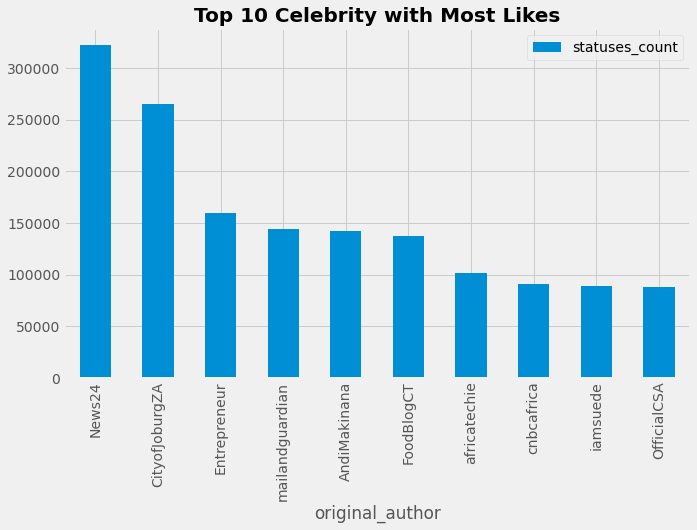

In [431]:
liked_chart = influential_data.groupby('original_author').agg({'statuses_count': 'max'})\
                    .sort_values(by='statuses_count', ascending=False)[:10]
liked_chart.plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Celebrity with Most Likes', size=20, fontweight='bold', fontfamily='sans-serif')
plt.show()

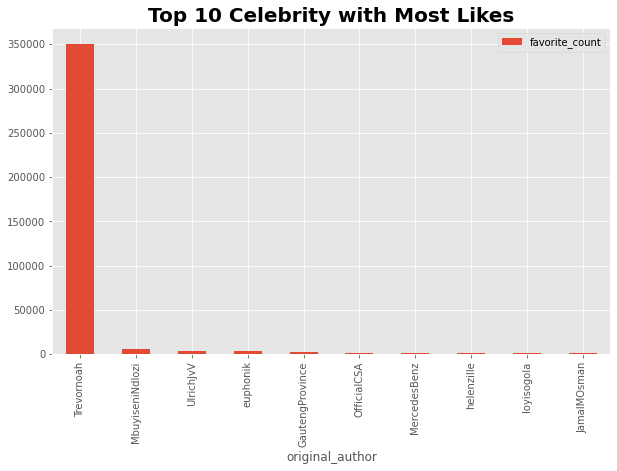

In [156]:
liked_chart = influential_data.groupby('original_author').agg({'favorite_count': 'max'})\
                    .sort_values(by='favorite_count', ascending=False)[:10]
liked_chart.plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Celebrity with Most Likes', size=20, fontweight='bold', fontfamily='sans-serif')
plt.show()

With Trevor Noah's likes hiding all others influencers likes we can omit his likes and see how others compare

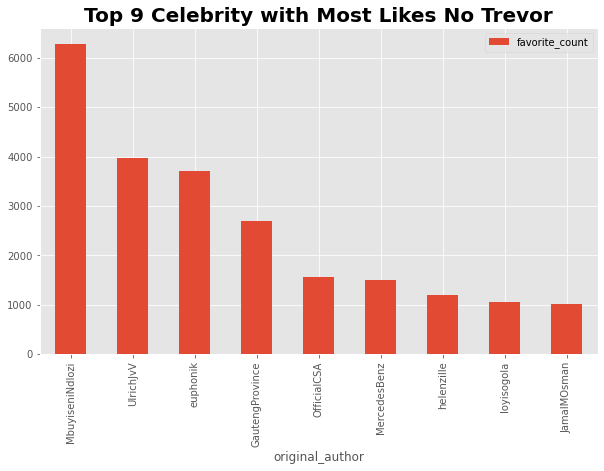

In [172]:
liked_chart_no_trevor = liked_chart.reset_index()
no_trevor = liked_chart_no_trevor[liked_chart_no_trevor['original_author'] != 'Trevornoah']
no_trevor.set_index('original_author', inplace=True)
no_trevor.plot(kind='bar', figsize=(10, 6))
plt.title('Top 9 Celebrity with Most Likes No Trevor', size=20, fontweight='bold', fontfamily='sans-serif')
plt.show()

MbuyiseniNdlozi has the most like here (6288) with UlrichJvV following with (3988). JamalMOsman has the least most like among the top 10 with a maximum like of 1009.

Which Influencers had the most shared tweets?

In [174]:
influential_data.groupby('original_author').agg({'statuses_count':'max'}).\
                sort_values(by='statuses_count', ascending=False)

,statuses_count
original_author,
News24,322628
CityofJoburgZA,265130
Entrepreneur,159489
mailandguardian,144225
AndiMakinana,142222
FoodBlogCT,137296
africatechie,101237
cnbcafrica,91444
iamsuede,88732


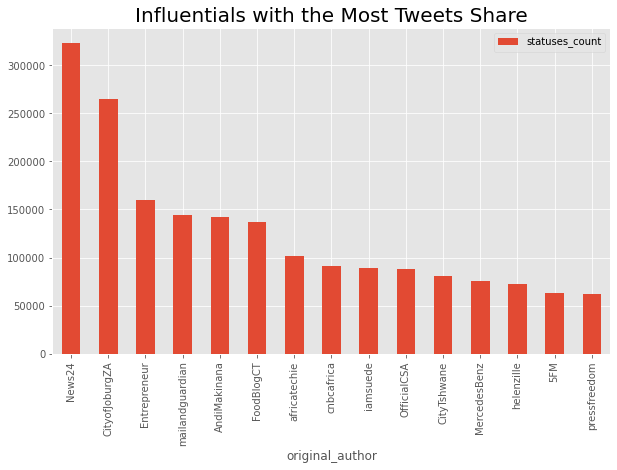

In [176]:
tweets_shared = influential_data.groupby('original_author').agg({'statuses_count':'max'}).\
                sort_values(by='statuses_count', ascending=False)
tweets_shared[:15].plot(kind='bar', figsize=(10, 6))
plt.title('Influentials with the Most Tweets Share', size=20)
plt.show()

News24 lead the most Tweets Shared. This further emphasis the fact that latest juicy news or event are constantly and frequently been shared on Twitter, even though News24 had reletively low likes and retweets as compared to Trevors a Comedian Tweets.

To a more indepth Analysis ....

 <p>Which top 5 of Hashtags were Influencers using</p>
 Hashtags is defined according to Merriem Webster Dictionary as a word or phrase preceded by a hash sign (#), used on social media websites and applications, especially Twitter, to identify messages on a specific topic.

First let identify the Number of unique Hashtags in our Influencer data

In [177]:
no_of_unique_hash = influential_data['hashtags'].nunique()
print(f'Total Number of Unique Hashtags {no_of_unique_hash}')

Total Number of Unique Hashtags 842


So we can conclude that 842 diffrent topics were discussed among these influencers (91) and the rest of the world

In [178]:
influential_data.groupby(['hashtags', 'original_author']).\
            agg({'retweet_count': 'mean', 'favorite_count': 'mean'})

,,retweet_count,favorite_count
hashtags,original_author,,
,Aynte,3.375000,23.187500
"100daysoflockdown, SoWhatNow",GarethCliff,29.000000,238.000000
10XDMGathering,BrendanSAfrica,0.000000,2.000000
10xDMGathering,BrendanSAfrica,1.500000,2.000000
15YEARSOFE,gertjohan,5.000000,57.000000
2020visions,mikestopforth,0.000000,0.000000
21daysLockdownSA,IECSouthAfrica,4.000000,5.000000
3TCricket,OfficialCSA,12.800000,88.600000
"3TCricket, RainsMakesPlay",OfficialCSA,6.000000,84.000000


Grouping By all the Hashtags does not seem to deliver much information has we have close to a thousand hashtags so what i did was get the most used hashtags and get the retweet_count as well as likes. Also get the author and derive insight. <br>
With Selecting the most used hashtags it gives us which topic trended the most and using the authors we can get and group authors based on topics they are known to discuss or tweet about 

In [187]:
hashtags_t = influential_data['hashtags'].value_counts()[:11]
ht_list = hashtags_t.index.drop('None')

In [192]:
ht_list

Index(['COVID19', 'LiveAMP', 'Nigeria', 'CNBCConversation', 'euNITE947',
       'Knysna', 'AgainstAllOdds', '', 'SouthAfrica', 'MTVBaseLounge'],
      dtype='object')

In [194]:
influential_data['common_hashtags'] = pd.Series(len(influential_data))
common_hash = []
for ht in influential_data['hashtags']:
    if ht == ht_list[0]:
        common_hash.append(ht_list[0])
    elif ht == ht_list[1]:
        common_hash.append(ht_list[1])
    elif ht == ht_list[2]:
        common_hash.append(ht_list[2])
    elif ht == ht_list[3]:
        common_hash.append(ht_list[3])
    elif ht == ht_list[4]:
        common_hash.append(ht_list[4])
    elif ht == ht_list[5]:
        common_hash.append(ht_list[5])
    elif ht == ht_list[6]:
        common_hash.append(ht_list[6])
    elif ht == ht_list[8]:
        common_hash.append(ht_list[8])
    elif ht == ht_list[9]:
        common_hash.append(ht_list[9])
    else: common_hash.append('NotCommon')

len(common_hash)

5370

In [195]:
influential_data['common_hashtags'] = common_hash
influential_data.head(3)

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,followers_count,friends_count,statuses_count,hashtags,user_mentions,place,place_coord_boundaries,popularity_score,reach_score,relevance_score,common_hashtags
0,1283897012442877954,Thu Jul 16 22:51:16 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...","On July 9, the Lebanese attorney general’s off...",On July Lebanese attorney generals office file...,"Sentiment(polarity=-0.4, subjectivity=0.55)",-0.4,0.55,en,13,10,pressfreedom,False,219084,2050,62402,None,NaN,NaN,Worldwide,23,221134,281509,NotCommon
1,1283866508742012928,Thu Jul 16 20:50:03 +0000 2020,"<a href=""https://www.hootsuite.com"" rel=""nofol...",Voice of America visa review could put journal...,Voice America visa review could put journalist...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.00,en,13,9,pressfreedom,False,219084,2050,62402,None,NaN,NaN,Worldwide,22,221134,281508,NotCommon
2,1283862309866217480,Thu Jul 16 20:33:22 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",“Belarusian authorities must stop detaining an...,Belarusian authorities must stop detaining pro...,"Sentiment(polarity=0.0, subjectivity=0.0)",0.0,0.00,en,8,6,pressfreedom,False,219084,2050,62402,None,NaN,NaN,Worldwide,14,221134,281500,NotCommon


In [196]:
influential_data['common_hashtags'].value_counts()

NotCommon           5163
COVID19               58
LiveAMP               31
Nigeria               23
CNBCConversation      20
euNITE947             17
AgainstAllOdds        16
Knysna                16
MTVBaseLounge         13
SouthAfrica           13
Name: common_hashtags, dtype: int64

In [421]:
influential_data.groupby(['common_hashtags', 'original_author']).\
            agg({'retweet_count': 'mean', 'favorite_count': 'mean'}).\
            sort_values(by=['common_hashtags', 'favorite_count'],ascending=False)

retweet_count  favorite_count
common_hashtags  original_author                               
euNITE947        euphonik              4.882353       39.705882
SouthAfrica      rangerdiaries        11.000000       22.000000
                 AfricaCheck           7.714286        7.428571
                 ThinkAfricaFeed       5.000000        6.000000
                 TheAfricaReport       2.250000        3.750000
NotCommon        Trevornoah         6809.000000    31095.764706
                 MbuyiseniNdlozi     351.125000     1654.291667
                 UlrichJvV            72.969697      609.030303
                 euphonik             43.315789      333.421053
                 GarethCliff          22.170732      126.853659
                 OfficialCSA          19.082192      105.917808
                 liveamp               9.687500      101.281250
                 MercedesBenz          8.789474       74.294737
                 schneiderhome        18.255319       63.446809
                 helenzille           10.529412       62.529412
                 MTVBaseAfrica        12.870968       59.338710
                 loyisogola            7.305556       56.305556
                 audisouthafrica       6.042105       51.978947
                 savetherhino         13.328358       44.925373
                 News24               15.666667       38.755556
                 JamalMOsman          17.441860       36.302326
                 gertjohan             2.520000       33.760000
                 OkayAfrica           14.962025       32.430380
                 Entrepreneur         13.031250       31.166667
                 GautengProvince      18.538462       30.846154
                 Camfed                7.438596       28.842105
                 Aynte                 4.000000       28.571429
                 5FM                   4.691489       28.265957
                 gettleman            10.840000       27.560000
                 ONEinAfrica          10.818182       24.303030
                 PeterGreste          10.420000       21.980000
                 PatrickNgowi          9.300000       19.600000
                 CityTshwane           9.049383       18.037037
                 AndiMakinana          8.183099       17.859155
                 pressfreedom         11.350000       16.216667
                 rangerdiaries         7.357143       16.163265
                 africatechie          5.142857       13.040816
                 BobSkinstad           0.800000       12.900000
                 Equal                 0.571429       12.773810
                 NDOCKenya            11.111111       12.472222
                 malonebarry           2.462963       10.574074
                 cx73                  0.835443       10.556962
                 Moadow                2.625000       10.125000
                 africaprogress        5.987179        9.679487
                 ayittey               3.988506        9.666667
                 JamesCopnall          0.923077        9.076923
                 SamsungSA             0.731343        8.641791
                 IFCAfrica             3.897959        8.306122
                 mailandguardian       6.200000        8.080000
                 KahnMorbee            1.095238        8.000000
                 willintune            4.846154        7.615385
                 hartleyr              3.914286        7.428571
                 geoffreyyork          4.620000        6.960000
                 MadeItInAfrica        3.234568        6.876543
                 ThisIsAfricaTIA       3.712329        6.589041
                 BrendanSAfrica        1.548387        6.258065
                 IECSouthAfrica        3.786667        5.693333
                 forbesafrica          2.108434        5.578313
                 JendayiFrazer         1.500000        5.000000
                 t                     0.940000        4.870000
                 AfricaResearch        3.275000        4.750000
  

from the result above, we can provide answers to questions like when so so user e.g **savetherhino**  tweeted about so topic e.g COVID19, what was the Average retweet count and the average likes. Also we can group Author that is influencers based on topics discussed or **hashtags** they used in their tweets

**Extract the top 5 unique hashtags these influencers and government officials used in
their top 10 retweets.  Group them based on their top 5 hashtags similarities**


In [201]:
ht_tweets = influential_data[influential_data['hashtags'] != 'None']
ht_tweets.shape

(1449, 24)

Top 5 unique hashtags

In [245]:
ht_tweets['hashtags'].value_counts()[:5]

COVID19             58
LiveAMP             31
Nigeria             23
CNBCConversation    20
euNITE947           17
Name: hashtags, dtype: int64

In [225]:
tt = ht_tweets.groupby(['original_author'])['common_hashtags'].value_counts().sort_values(ascending=False)

In [231]:
tt = pd.DataFrame(tt)
tt.columns = ['counts_hashtags']
tt.reset_index(inplace=True)
tt.columns

Index(['original_author', 'common_hashtags', 'counts_hashtags'], dtype='object')

Group them Based on their top 5 hashtags similarities

In [244]:
tt=tt[tt['common_hashtags'] != 'NotCommon']

tt.groupby(['common_hashtags', 'original_author']).sum().sort_values(by='counts_hashtags', ascending=False)


,,counts_hashtags
common_hashtags,original_author,
LiveAMP,liveamp,31
CNBCConversation,cnbcafrica,20
euNITE947,euphonik,17
COVID19,GautengProvince,17
AgainstAllOdds,cnbcafrica,16
Knysna,cx73,16
COVID19,IFCAfrica,15
Nigeria,africamedia,14
MTVBaseLounge,MTVBaseAfrica,13


In [248]:
influential_data['place_coord_boundaries'].value_counts()

South Africa                      892
Africa                            431
Johannesburg, South Africa        315
London                            293
Cape Town                         242
Cape Town, South Africa           166
Johannesburg                      135
Nairobi, Kenya                    109
Pacific Time Zone                 100
Rivonia Road. Sandton              99
Irvine, CA                         96
Knysna | South Africa              95
Stuttgart, Germany                 95
London, New York, Hong Kong        93
London, England                    92
South Africa- Gauteng              88
Washington, DC, USA                87
Rainbow Road                       84
continent | diaspora | world       79
Geneva                             78
Paris, France                      77
Auckland, New Zealand              73
Amsterdam, The Netherlands         72
California, USA                    70
Lancaster, PA                      68
Sub-Saharan Africa                 65
Worldwide   

Most of the Tweets were tweeted in South Africa <br>
Which place coordinate has the most tweet shared and the most retweeted tweets and likes?

In [253]:
influential_data.groupby('place_coord_boundaries').agg({'statuses_count':'max'}).\
        sort_values(by='statuses_count', ascending=False)

,statuses_count
place_coord_boundaries,
South Africa,322628
"Braamfontein, Johannesburg",265130
"Irvine, CA",159489
"Johannesburg, South Africa",144225
"Cape Town, South Africa",142222
Cape Town,137296
Cameroon,101237
Africa,91444
Los Angeles,88732


In [254]:
influential_data[influential_data['original_author'] == 'Trevornoah'].groupby('place_coord_boundaries').agg({'statuses_count':'max'}).\
        sort_values(by='statuses_count', ascending=False)

,statuses_count
place_coord_boundaries,
"New York, NY",11185


The User with the **most retweet** tweeted from `New York` <br>
Could the location had affected the number of retweet he got for all his tweets? Or maybe it was just that his tweets were so funny people tends to share or retweets alot. <br>

I could not provide answer to this question because the data i had does not provide reply tweets and people retweeting informations

In [255]:
influential_data[influential_data['original_author'] == 'News24'].groupby('place_coord_boundaries').agg({'statuses_count':'max'}).\
        sort_values(by='statuses_count', ascending=False)

,statuses_count
place_coord_boundaries,
South Africa,322628


The User with the **most shared Tweets** tweeted from `South Africa`

Which Influencer has the Highest Popularity Score?


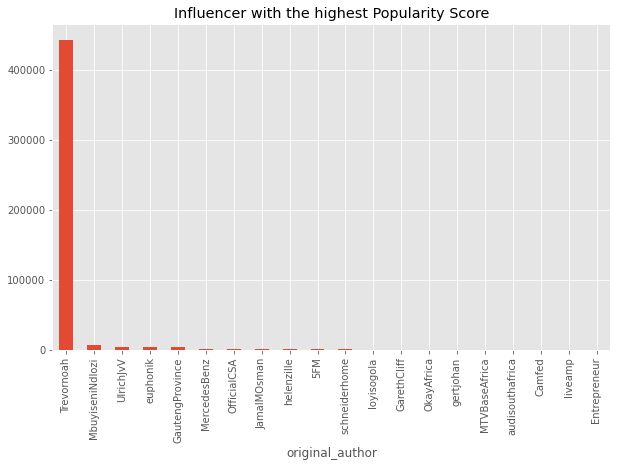

In [271]:
# top 20 influencers based on popularity Score
popul_20 = influential_data.groupby('original_author')['popularity_score'].max().sort_values(ascending=False)[:20]
popul_20.plot(kind='bar', figsize=(10, 6))
plt.title('Influencer with the highest Popularity Score')
plt.show()

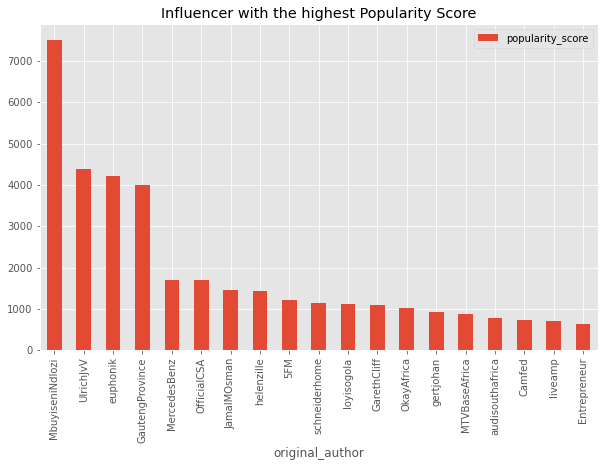

In [272]:
popul_20 = popul_20.reset_index()
popul_20 = popul_20[popul_20['original_author'] != 'Trevornoah']
popul_20 = popul_20.set_index('original_author')
popul_20.plot(kind='bar', figsize=(10, 6))
plt.title('Influencer with the highest Popularity Score', size=20)
plt.show()

Top 10 Celebrity with the most shared Tweets

Text(0.5, 1.0, 'Top Hashtags Used by Influentials')

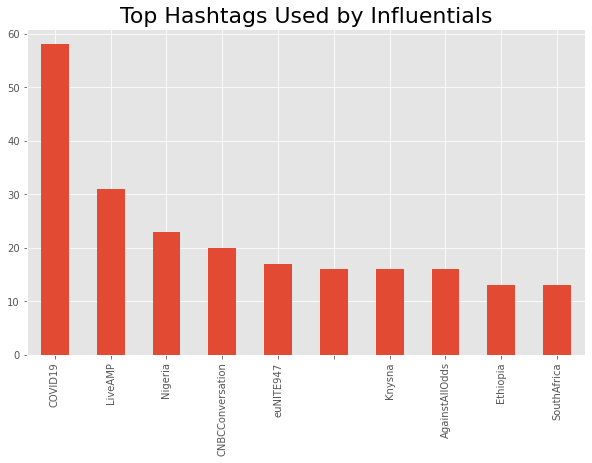

In [80]:
plt.style.use('ggplot')
influential_data['hashtags'].value_counts()[:10].plot.bar(figsize=(10, 6))
plt.title('Top 10 Hashtags Used by Influentials', size=20)

In [275]:
influential_data.columns

Index(['id', 'created_at', 'source', 'original_text', 'clean_text',
       'sentiment', 'polarity', 'subjectivity', 'lang', 'favorite_count',
       'retweet_count', 'original_author', 'possibly_sensitive',
       'followers_count', 'friends_count', 'statuses_count', 'hashtags',
       'user_mentions', 'place', 'place_coord_boundaries', 'popularity_score',
       'reach_score', 'relevance_score', 'common_hashtags'],
      dtype='object')

## African Leader

In [306]:
leader_data['popularity_score'] = leader_data['retweet_count'] + leader_data['favorite_count']
leader_data['reach_score'] = leader_data['followers_count'] - leader_data['friends_count']
leader_data['relevance_score'] = leader_data['popularity_score'] + leader_data['reach_score'] +\
                leader_data['statuses_count'] - leader_data['friends_count']

Number of Unique Leaders in the data

In [277]:
no_of_unique_leader = leader_data['original_author'].nunique()
print(f"The Number of Unique Leaders in the data is {no_of_unique_leader}")

The Number of Unique Leaders in the data is 34


Which Leader has the Most retweet, likes and statuses shared?

In [278]:
# Most Retweet
leader_data.groupby('original_author').agg({'retweet_count': 'max'})\
                    .sort_values(by='retweet_count', ascending=False)

,retweet_count
original_author,
MagufuliJP,6295
PaulKagame,5793
edmnangagwa,4416
NAkufoAddo,4264
MBuhari,2808
BorisJohnson,2770
CyrilRamaphosa,2744
WHO,2430
PresidentBio,1868


Top 10 Leaders with most Retweets count

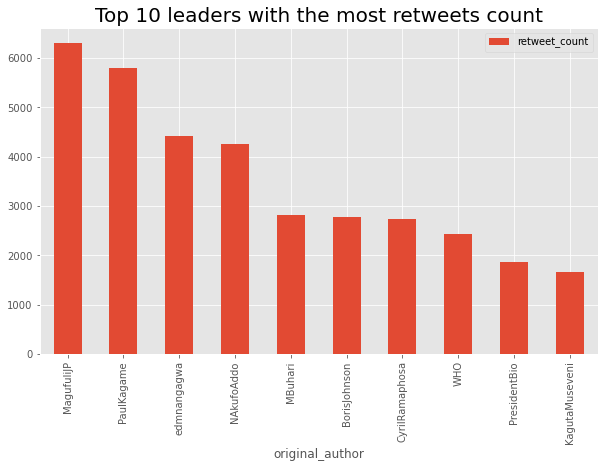

In [280]:
leader_data.groupby('original_author').agg({'retweet_count': 'max'})\
         .sort_values(by='retweet_count', ascending=False)[:10].plot(kind='bar', figsize=(10,6))
plt.title('Top 10 leaders with the most retweets count', size=20)
plt.show()

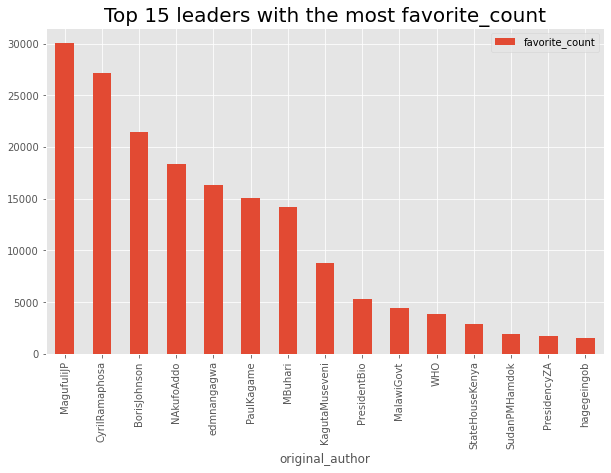

In [281]:
def plot_bar(data, groupby, agg_col, top):
    data.groupby(groupby).agg({agg_col: 'max'})\
             .sort_values(by=agg_col, ascending=False)[:top].plot(kind='bar', figsize=(10,6))
    plt.title(f'Top {top} leaders with the most {agg_col}', size=20)
    plt.show()
plot_bar(leader_data, 'original_author', 'favorite_count', 15)

MagufuliJP has the highest retweets count and likes for his tweets.

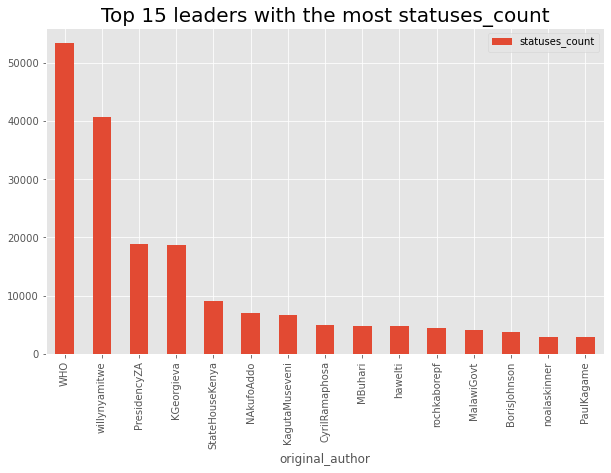

In [284]:
# Most Status Shared
plot_bar(data=leader_data, agg_col='statuses_count', top=15, groupby='original_author')

WHO - World Health Organization has the most status shared count. Indepth Analysis reveals that due to the outbreak of COVID 19, WHO tweets has grown exponetially has it seek to give and deliver timely informations to all of its followers. Talking about followers, which leader has the most follower count and which leader has the least friend count?

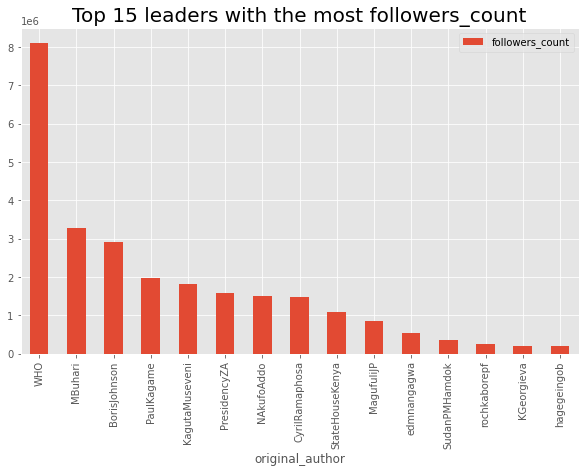

In [285]:
# most follower counts
plot_bar(leader_data, 'original_author', 'followers_count', 15)

WHO leads here as well followed by President Muhammadu Buhari who is closely followed by Boris Johnson the Prime Minister of United Kingdom. Hummmm United Kingdom is not an African Nation. This is an Outlier.

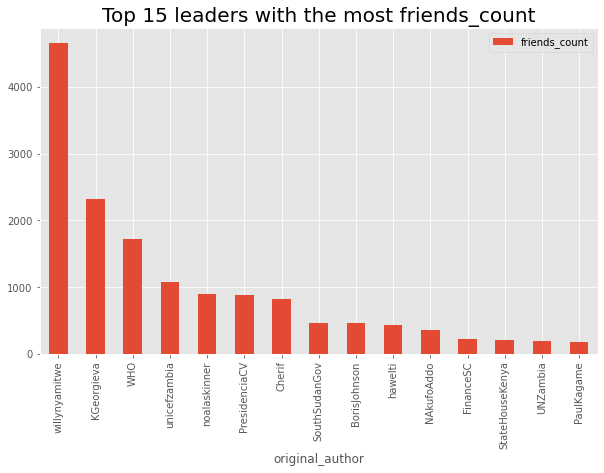

In [286]:
# least amount of friend
plot_bar(leader_data, 'original_author', 'friends_count', 15)

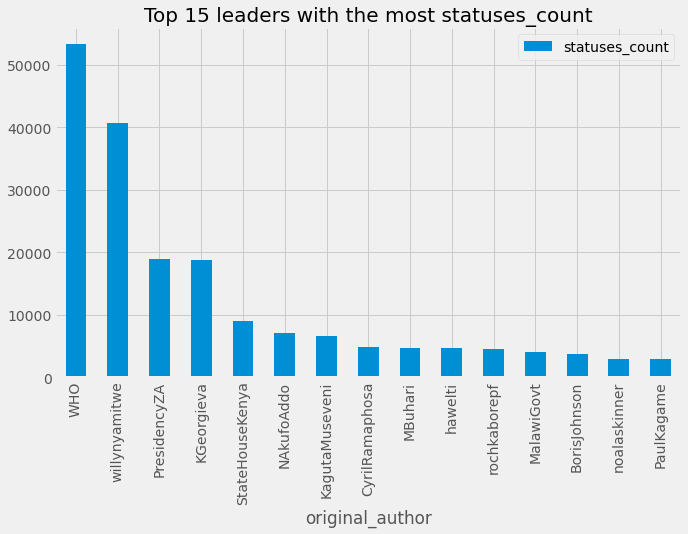

In [430]:
plot_bar(leader_data, 'original_author', 'statuses_count', 15)

${\textbf{The 10 Most Influential Leaders Twitter Users in Africa Based on Popularity Score}}$

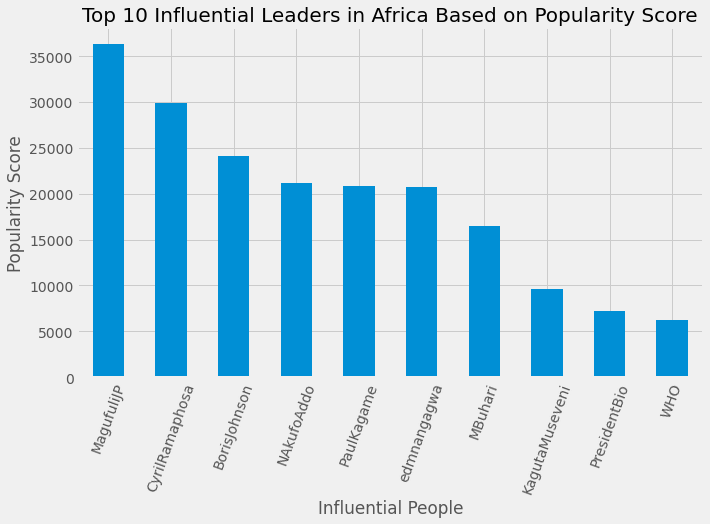

In [287]:
plt.style.use('fivethirtyeight')
leader_data.groupby('original_author')['popularity_score'].max().sort_values(ascending=False)[:10]\
                                    .plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Influential Leaders in Africa Based on Popularity Score', size=20)
plt.ylabel('Popularity Score')
plt.xlabel('Influential People')
plt.xticks(rotation=70)
plt.show()

In [304]:
def plot_bar_style(data, agg_col, top):
    data.groupby('original_author')[agg_col].max().sort_values(ascending=False)[:top]\
                                        .plot(kind='bar', figsize=(10, 6))
    plt.title(f'Top 10 Influential Leaders in Africa Based on {agg_col}', size=20)
    plt.ylabel(agg_col)
    plt.xlabel('Influential Leaders')
    plt.xticks(rotation=70)
    plt.show()

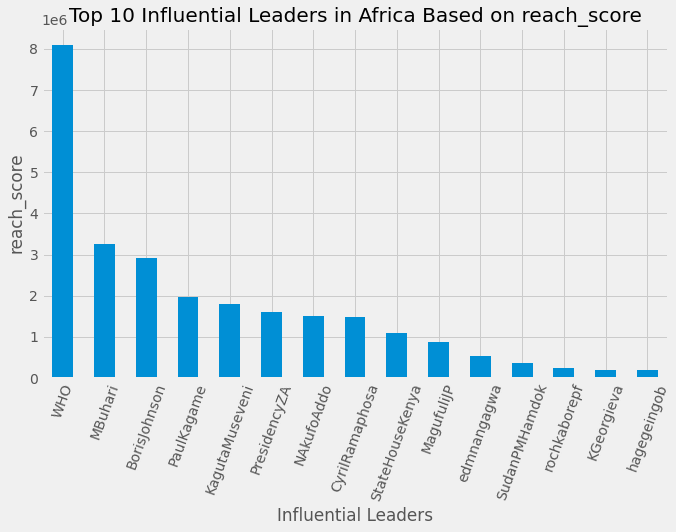

In [307]:
plot_bar_style(leader_data, 'reach_score', 15)

WHO is less Popular but has the highest value of reach score, followed by Nigerian President MBuhari who again is closely followed by Boris Johnson. Hagegeingob has the least reach score among the top 15.

In [323]:
# popular hashtags used by leaders
leader_data['hashtags'].value_counts()[:5]

COVID19                       82
Eritrea                       30
COVID19, FA4JR                19
FPE2020, MalawiDecides2020    14
SierraLeone                   11
Name: hashtags, dtype: int64

In [338]:
leader_tw_ht = leader_data[leader_data['hashtags'].isna() == False]
leader_tw_ht.shape

(479, 23)

In [339]:
# top 10 hashtags based on top retweets
most_cm_ht= []
for ht in leader_tw_ht['hashtags']:
    if str(ht).lower().startswith('co'):
        most_cm_ht.append('COVID19')
    else: most_cm_ht.append('other topic')
#     print(str(ht).lower().startswith('co'))
len(most_cm_ht)

479

In [340]:
leader_tw_ht['covid_topic'] = most_cm_ht

c:\users\abuton\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [349]:
tt = leader_tw_ht.groupby(['original_author'])['covid_topic'].value_counts().\
            sort_values(ascending=False)

In [351]:
# tt=tt[tt['common_hashtags'] != 'NotCommon']

tt.groupby(['covid_topic', 'original_author']).sum().sort_values(ascending=False)
tt = pd.DataFrame(tt)
tt.columns = ['counts_hashtags']
tt.reset_index(inplace=True)
tt.columns

Index(['original_author', 'covid_topic', 'counts_hashtags'], dtype='object')

In [356]:
tt.groupby(['covid_topic', 'original_author']).sum().\
            sort_values(by=['covid_topic', 'counts_hashtags'], ascending=False)


counts_hashtags
covid_topic original_author                 
other topic MalawiGovt                    43
            hawelti                       32
            KGeorgieva                    26
            PresidentBio                  25
            unicefzambia                  19
            FinanceSC                     18
            UNZambia                      17
            hagegeingob                   16
            PresidencyZA                  14
            WHO                           14
            BorisJohnson                   8
            TZSpokesperson                 8
            mohzambia                      8
            CyrilRamaphosa                 7
            PaulKagame                     7
            StateHouseKenya                7
            NAkufoAddo                     6
            edmnangagwa                    6
            SouthSudanGov                  5
            noalaskinner                   5
            USEmbalo                       4
            IssoufouMhm                    3
            willynyamitwe                  3
            KagutaMuseveni                 1
            MBuhari                        1
            PresidentABO                   1
            SudanPMHamdok                  1
COVID19     WHO                           26
            KGeorgieva                    23
            FinanceSC                     22
            UNZambia                      21
            unicefzambia                  16
            PaulKagame                     8
            PresidencyZA                   8
            PresidentBio                   8
            SouthSudanGov                  8
            mohzambia                      8
            StateHouseKenya                7
            TZSpokesperson                 5
            hagegeingob                    4
            CyrilRamaphosa                 3
            NAkufoAddo                     2
            noalaskinner                   2
            KagutaMuseveni                 1
            MalawiGovt                     1
            rochkaborepf                   1

In [358]:
leader_data['created_at'] = pd.to_datetime(leader_data['created_at'])
leader_data['created_at'].dtype

datetime64[ns, UTC]

In [362]:
who_df = leader_data[leader_data['original_author'] == 'WHO']
who_df.shape

(64, 23)

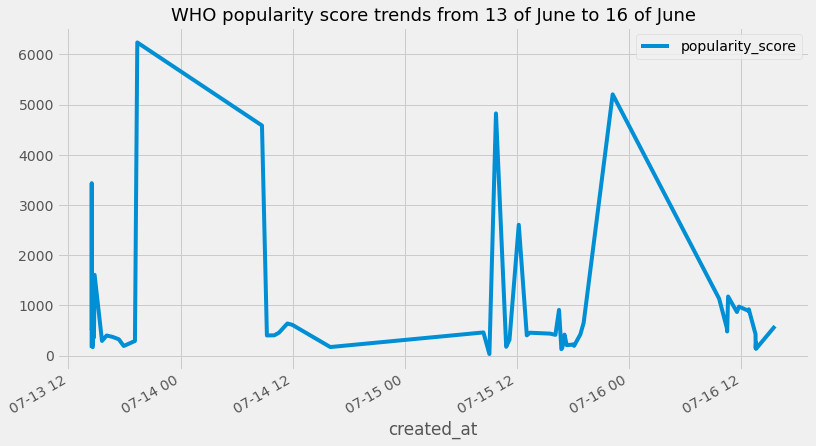

In [368]:
who_df[['created_at', 'popularity_score']].set_index('created_at').plot(kind='line', figsize=(12, 7))
plt.title('WHO popularity score trends from 13 of June to 16 of June', size=18)
plt.show()

World Health Organization Popularity Score tends to raise and fall as the day goes by

In [369]:
mbuhari_df = leader_data[leader_data['original_author'] == 'MBuhari']
mbuhari_df.shape

(99, 23)

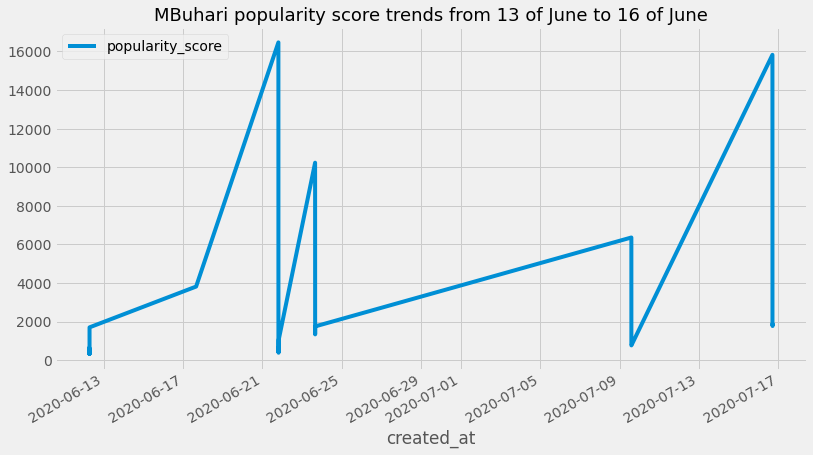

In [370]:
mbuhari_df[['created_at', 'popularity_score']].set_index('created_at').plot(kind='line', figsize=(12, 7))
plt.title('MBuhari popularity score trends from 13 of June to 16 of June', size=18)
plt.show()

Nigerian President tweets has it popularity score at peak on $2020-06-21$ and his following tweet has a more reduce score of less than 500. There was a constant increase in score starting from $2020-06-25$ till $2020-07-09$.

**Make a bar plot to show the fraction of influencers and top government officials by
hashtag.**


In [371]:
# combine both influencer celeb data and leader data
df = pd.concat([influential_data, leader_data], ignore_index=True, sort=False)
df.shape

(7099, 24)

In [377]:
df_ht = df[df['hashtags'] != 'None']
df_ht['hashtags'].value_counts()[:10]

COVID19             140
Eritrea              31
LiveAMP              31
Nigeria              23
CNBCConversation     20
COVID19, FA4JR       19
euNITE947            17
                     16
Covid19              16
AgainstAllOdds       16
Name: hashtags, dtype: int64

In [382]:
ht_list = []
for ht in df_ht['hashtags']:
    if str(ht).lower().startswith('co'):
        ht_list.append('COVID19')
    else:
         ht_list.append(ht)
#     print(str(ht).lower().startswith('co'))
df_ht['hashtags'] = ht_list
df_ht['hashtags'].value_counts()[:5]

COVID19             323
Eritrea              31
LiveAMP              31
Nigeria              23
CNBCConversation     20
Name: hashtags, dtype: int64

In [405]:
df.groupby('original_author')['popularity_score'].sum().sort_values(ascending=False)[:10]

original_author
Trevornoah         644381
BorisJohnson       497404
PaulKagame         368679
NAkufoAddo         270665
KagutaMuseveni     182668
MagufuliJP         159493
edmnangagwa        110242
CyrilRamaphosa     106637
MBuhari            104847
StateHouseKenya     64392
Name: popularity_score, dtype: int64

In [406]:
df = df[df['original_author'] != 'BorisJohnson']

In [413]:
popul_10 = df.groupby('original_author')['popularity_score'].sum().sort_values(ascending=False)[:10]
popul_10 = popul_10.reset_index()

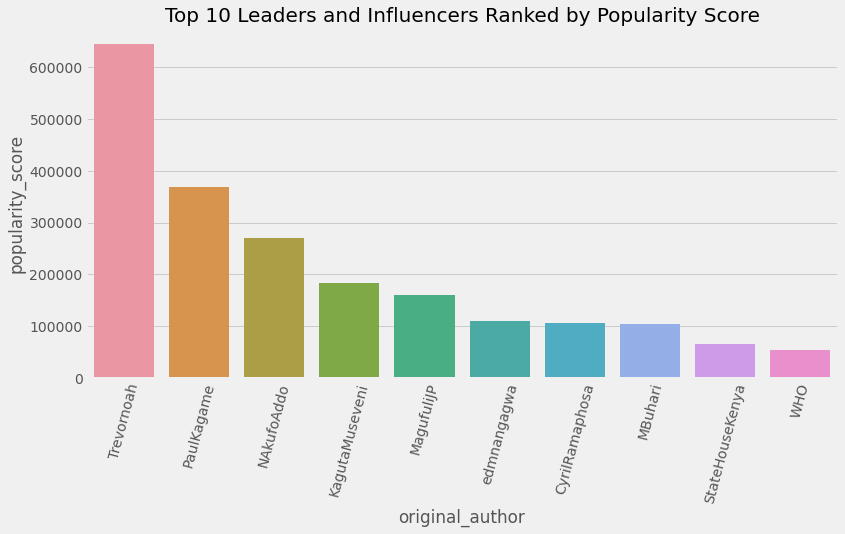

In [422]:
plt.figure(figsize=(12, 6))
sns.barplot(data=popul_10, x='original_author', y='popularity_score')
plt.title('Top 10 Leaders and Influencers Ranked by Popularity Score', size=20)
plt.xticks(rotation=75, fontsize=14)
plt.show()

In [386]:
df_ht['original_author'].nunique()

109

In [424]:
df.groupby('original_author')['popularity_score'].max().sort_values(ascending=False)[:5]

original_author
Trevornoah        442645
MagufuliJP         36327
CyrilRamaphosa     29915
NAkufoAddo         21204
PaulKagame         20836
Name: popularity_score, dtype: int64

### African Leaders Tweets

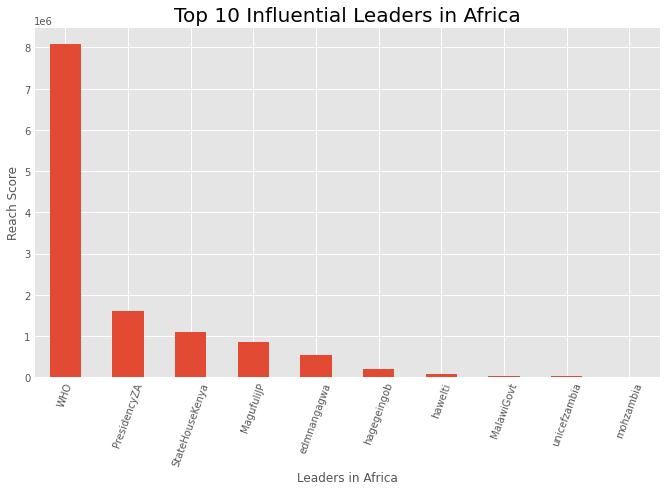

In [188]:
plt.style.use('ggplot')
leader_df.groupby('original_author')['reach_score'].max().sort_values(ascending=False)[:10]\
                                    .plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Influential Leaders in Africa', size=20)
plt.ylabel('Reach Score')
plt.xlabel('Leaders in Africa')
plt.xticks(rotation=70)
plt.show()

In [429]:
pd.DataFrame(df['original_author'].value_counts())

,original_author
t,100
SandtonCity,99
TechCentral,99
MBuhari,99
rangerdiaries,99
KagutaMuseveni,98
Entrepreneur,96
ParliamentofRSA,95
audisouthafrica,95
FoodBlogCT,95


**Thank You**